# PNEUMONIA
### Definition
An infection in one or both lungs, caused by bacteria, virus or fungi. It involves inflammation of alveoli and causes difficulty in breathing. With Pneumonia, air sacs will fluid or pus. The disease can be life threatening, particularly to infants and people above 65 years of age.

### Symptoms
Symptoms can be,
1. Cough
2. Fever, sweating and chills
3. Shallow breathing
4. Chest pain

### Cause
Causes for Pneumonia are,
1. Bacteria - **Streptococcus pneumoniae**
2. Influenza
3. SARS-CoV2 (virus that cause Covid-19)

### Risk Factors
1. Conditions that weaken the immune system. Eg. AIDS
2. **Chronic Obstructive Pulmonary Disease** (COPD)
3. Diabetes
4. Old Age
5. Lack of proper Nutrition

### How to determine via Chest X-rays
When interpreting the x-ray, the radiologist will look for white spots in the lungs (called infiltrates) that identify pneumonia.

# DATASET

#### Structure
The dataset is organized into three folders - train, val and test, each having two subfolders (for corresponding class) **NORMAL** and **PNEUMONIA**.
#### Source
The chest X-ray images were taken from pedriatic patients from Guangzhou Women and Children’s Medical Center, China. All chest radiographs were initially scanned for quality control by removing the low quality or unreadable scans.

#### Link for the dataset - [Kaggle - Chest X-ray Images](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

In [1]:
import numpy as np
import pandas
import seaborn
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras

In [3]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, classification_report

> Let's have a look at some sample images of both classes - **NORMAL** and **PNEUMONIA**

In [4]:
X = []
image = keras.preprocessing.image.load_img('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0129-0001.jpeg',
                                           color_mode = 'grayscale', target_size = (128,128))
X.append(keras.preprocessing.image.img_to_array(image))

image = keras.preprocessing.image.load_img('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0178-0001.jpeg',
                                           color_mode = 'grayscale', target_size = (128,128))
X.append(keras.preprocessing.image.img_to_array(image))

In [5]:
image = keras.preprocessing.image.load_img('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1005_virus_1688.jpeg',
                                           color_mode = 'grayscale', target_size = (128,128))
X.append(keras.preprocessing.image.img_to_array(image))

image = keras.preprocessing.image.load_img('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1018_virus_1706.jpeg',
                                           color_mode = 'grayscale', target_size = (128,128))
X.append(keras.preprocessing.image.img_to_array(image))

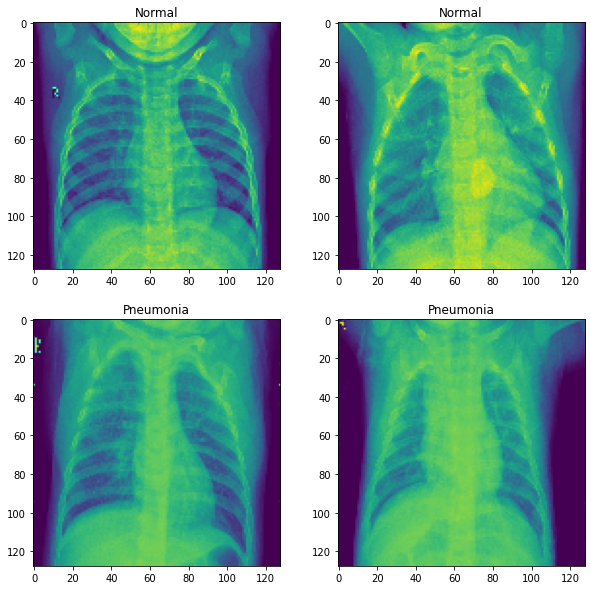

In [6]:
fig = plt.figure(figsize = (10,10))

for i in range (4) :
    plt.subplot(220+i+1)
    plt.imshow (X[i])
    if i < 2 :
        plt.title('Normal')
    else :
        plt.title('Pneumonia')

> On observing the images, some subtle differences can be noticed but let's leave the task of understanding these patterns to our **CNN**. We build a convolutional Neural network with three convolutional and MaxPooling layers. The image is flattened and fed to a hidden layer. The output of the network is the probablity of belonging to either class.

In [7]:
def cnn (num_filters_1, num_filters_2, num_filters_3, hidden_nodes) :
    
    # create the cnn  model
    model = keras.models.Sequential()
    model.add(keras.Input(shape = (128, 128, 1, )))
    
    # 1st convolution layer
    model.add(keras.layers.Conv2D(num_filters_1, (3,3), padding = 'valid', kernel_regularizer = 'l2'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.MaxPooling2D((2,2), padding = 'valid'))
    
    # 2nd convolution layer
    model.add(keras.layers.Conv2D(num_filters_2, (3,3), padding = 'valid', kernel_regularizer = 'l2'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.MaxPooling2D((2,2), padding = 'valid'))
    
    # 3rd convolution layer
    model.add(keras.layers.Conv2D(num_filters_3, (3,3), padding = 'valid', kernel_regularizer = 'l2'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.MaxPooling2D((2,2), padding = 'valid'))
    
    # flatten and hidden layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(hidden_nodes, kernel_regularizer =  'l2'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.2))
    
    # output layer
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))
    
    # compile the model
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

### Layers
#### Convolution layer
Kernels or filters are applied on this layer, which are convolved with portions of images to capture specific features (some capture edges, others capture contrast, etc). This also assists in reducing image size. Filters can be considered as weights for images (which they are sort of).

#### BarchNormalization
It happens that the cost function curve may thin out at some axis. So this normalizes the Inputs for faster training. This causes the cost curve to look something like the figure below.

![Image of cost function after normalization](https://i0.wp.com/www.adeveloperdiary.com/wp-content/uploads/2018/11/How-to-visualize-Gradient-Descent-using-Contour-plot-in-Python-adeveloperdiary.com-3.jpg?resize=640%2C480)

#### DropOut Layer
Asists in regularizing the weights by randomly deleting some units, so that the other nodes don't get to accustomed to the inputs and able to take variations into account.

#### Max Pooling Layer
Move a window along the image to capture the dominant features in the image. Here the window size is (2,2).

In [8]:
train_path = '../input/chest-xray-pneumonia/chest_xray/train/'
test_path  = '../input/chest-xray-pneumonia/chest_xray/test/'
eval_path  = '../input/chest-xray-pneumonia/chest_xray/val/'

> Create a function to generate **training set, eval set and test set**

In [9]:
import os
def give_set (path) :
    
    X = []
    y = []
    for label in os.listdir(path) :
        for img in os.listdir(path+label+'/') :
            image = keras.preprocessing.image.load_img(path+label+'/'+img, color_mode = 'grayscale', target_size = (128,128))
            X.append(keras.preprocessing.image.img_to_array(image))
            y.append(1 if label == 'PNEUMONIA' else 0)
    X = np.array(X, dtype = float)
    y = np.array(y)
    return X, y

In [10]:
X_train, y_train = give_set(train_path)
X_eval, y_eval = give_set(eval_path)
X_test, y_test = give_set(test_path)

In [11]:
X_train /= 255.0
X_eval  /= 255.0
X_test  /= 255.0

In [12]:
print(X_train.shape)
print(y_train.shape)

(5216, 128, 128, 1)
(5216,)


Text(0, 0.5, 'Frequency')

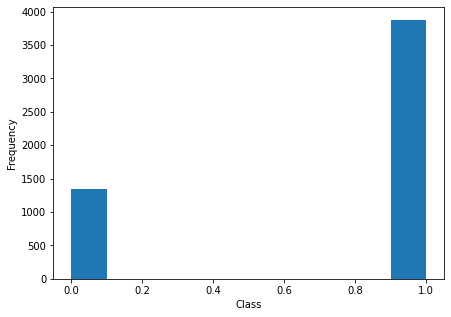

In [13]:
fig = plt.figure(figsize = (7,5))
plt.hist(y_train)
plt.xlabel('Class')
plt.ylabel('Frequency')

In [14]:
print(X_eval.shape)
print(y_eval.shape)

(16, 128, 128, 1)
(16,)


Text(0, 0.5, 'Frequency')

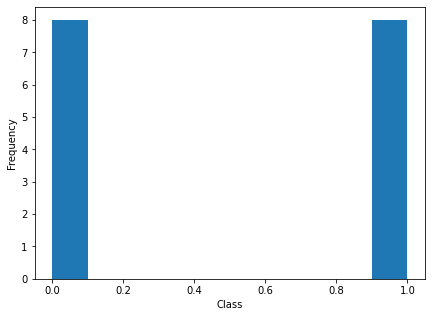

In [15]:
fig = plt.figure(figsize = (7,5))
plt.hist(y_eval)
plt.xlabel('Class')
plt.ylabel('Frequency')

In [16]:
print(X_test.shape)
print(y_test.shape)

(624, 128, 128, 1)
(624,)


Text(0, 0.5, 'Frequency')

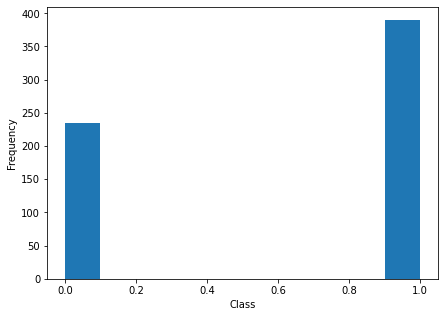

In [17]:
fig = plt.figure(figsize = (7,5))
plt.hist(y_test)
plt.xlabel('Class')
plt.ylabel('Frequency')

> To tackle the Data imbalance issue, Augmentation is done, using **ImageDataGenerator** method. The new images generated will be, \
    1. Random shifts. \
    2. Flipped Horizontally.

In [18]:
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1)

In [19]:
train_gen.fit(X_train)

> Perform **RandomizedSearch** for hyperparameter tuning. Select the best of parameters for training the model.

In [20]:
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn = cnn, verbose = 1)

In [21]:
param = {'num_filters_1' : [135,170], 'num_filters_2' : [60,100],
         'num_filters_3' : [35 , 50], 'hidden_nodes'  : [35, 50]}
grd = RandomizedSearchCV(estimator = model, param_distributions = param, cv = KFold(n_splits = 3, shuffle = True, random_state = 1), verbose = 1)

In [ ]:
search = grd.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 0)

In [ ]:
print(search.best_params_)

In [24]:
model = cnn(135, 60, 35, 35)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 135)     1350      
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 135)     540       
_________________________________________________________________
activation_4 (Activation)    (None, 126, 126, 135)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 126, 126, 135)     0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 135)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 60)        72960     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 60)       

In [25]:
reduce = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience  = 5)
perf = model.fit(train_gen.flow(X_train, y_train, batch_size = 32), epochs = 300, validation_data = (X_eval, y_eval), callbacks = [reduce])

Epoch 1/300
163/163 [==============================] - 11s 61ms/step - loss: 1.8426 - accuracy: 0.8524 - val_loss: 2.4717 - val_accuracy: 0.5000
Epoch 2/300
163/163 [==============================] - 10s 61ms/step - loss: 0.5661 - accuracy: 0.9118 - val_loss: 2.5419 - val_accuracy: 0.5000
Epoch 3/300
163/163 [==============================] - 10s 64ms/step - loss: 0.3814 - accuracy: 0.9222 - val_loss: 2.7534 - val_accuracy: 0.5000
Epoch 4/300
163/163 [==============================] - 10s 61ms/step - loss: 0.3468 - accuracy: 0.9178 - val_loss: 3.0431 - val_accuracy: 0.5000
Epoch 5/300
163/163 [==============================] - 10s 61ms/step - loss: 0.3290 - accuracy: 0.9142 - val_loss: 1.2699 - val_accuracy: 0.5000
Epoch 6/300
163/163 [==============================] - 10s 59ms/step - loss: 0.3275 - accuracy: 0.9263 - val_loss: 1.7700 - val_accuracy: 0.5000
Epoch 7/300
163/163 [==============================] - 10s 63ms/step - loss: 0.3350 - accuracy: 0.9146 - val_loss: 0.6761 - val_ac

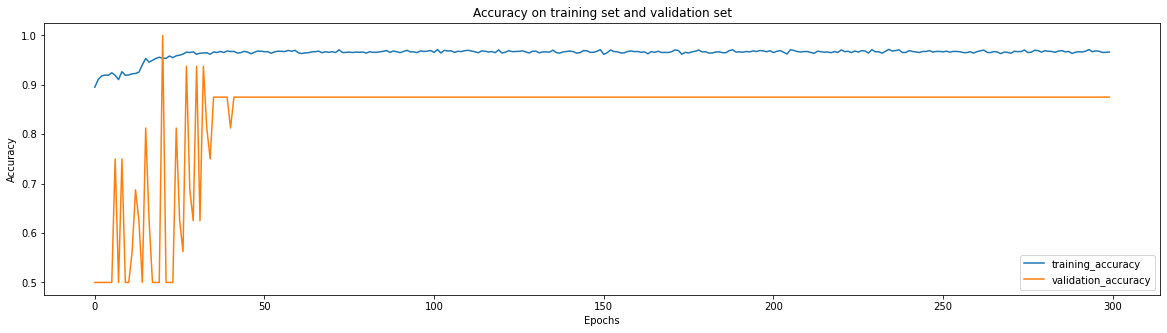

In [26]:
fig = plt.figure(figsize = (20,5))
plt.plot(perf.history['accuracy'])                   # accuracy for the training set
plt.plot(perf.history['val_accuracy'])               # sccuracy for the validate set
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.title('Accuracy on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

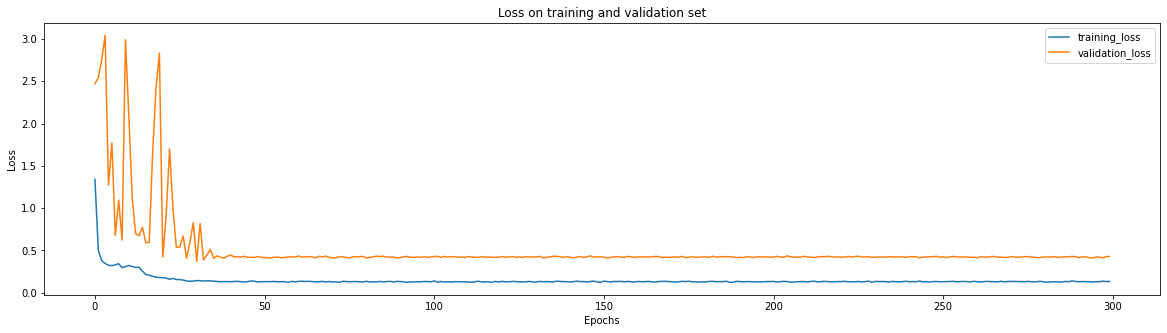

In [27]:
fig = plt.figure(figsize = (20,5))
plt.plot(perf.history['loss'])                       # loss for the training set
plt.plot(perf.history['val_loss'])                   # loss for the validate set
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss on training and validation set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [28]:
model.save('./pnue_model.h5')

> There is a strange behavious observed in loss and accuracy for validation data. They fail to converge even at larger epochs as the model learns. They have very **large variance** (ranging from 50% to 93% accuracy). However, this is not reflected in the test set.

In [29]:
y_pred = model.predict(X_test)

In [30]:
print(y_pred.shape)

(624, 1)


In [31]:
y_pred = np.array(y_pred.reshape(-1))

In [32]:
print(y_pred.shape)

(624,)


In [33]:
y_pred = np.around(y_pred)

In [34]:
y_pred = np.array(y_pred, dtype = int)

In [35]:
print(y_pred[:10])
print(y_test[:10])

[1 1 1 1 1 0 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]


> Overall Perfromance of the model on the test set

In [36]:
print('Accuarcy : ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuarcy : 0.8814102564102564
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       234
           1       0.87      0.95      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624



> Draw a **confusion matrix** to evaluate the perfromance of the model

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

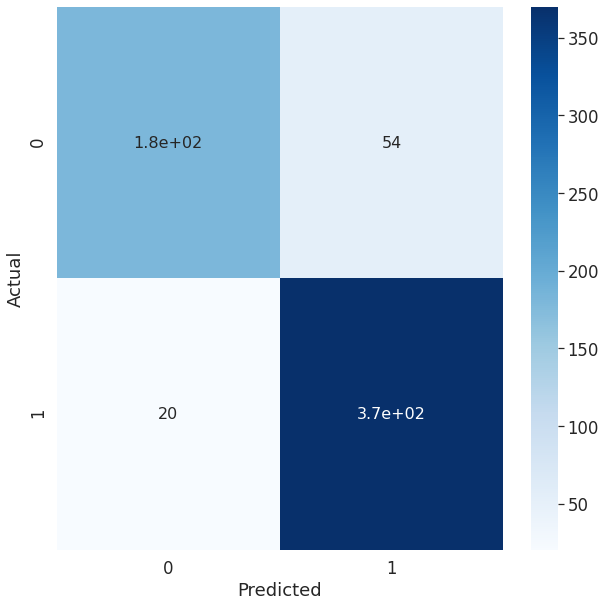

In [39]:
from sklearn.metrics import confusion_matrix
data = confusion_matrix(y_test, y_pred)
df_cm = pandas.DataFrame(data, columns = np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
seaborn.set(font_scale = 1.5)
seaborn.heatmap(df_cm, cmap = 'Blues', annot = True, annot_kws = {'size' : 16})